# Car Parking checker


Enric Ferrera González  
Miguel López Manzanares  
Joan Marc  

El objectiu del projecte de visió per computador es crear un programa que comprovi les plaçes d'aparcament d'un parking. Si están buides o plenes y en cas de que estiguin plenes, detectar la matrícula del coche, el color y si es pot la marca.  

Es realitzará de dues maneres, primer amb métodes clásics de la visió per computador y després amb métodes moderns com, per exemple, les xarxes neuronals. 

# Part clàsica

### 1. Dectectar línies
Per començar la part clàsica volem detectar les línies de les plaçes d'aparcament.

Per detectar les línies d'aparcament en una imatge d'un aparcament utilitzant mètodes clàssics de visió per computador, es poden seguir els següents passos:

1. **Conversió a escala de grisos:** Facilita el processament de la imatge.
2. **Filtrat de soroll:** S'utilitza un filtre com el Gaussian Blur per reduir el soroll.
3. **Detecció de vores:** S'aplica l'algoritme de Canny per detectar les vores de la imatge.
4. **Transformada de Hough:** Permet detectar línies rectes a la imatge, que corresponen a les línies d'aparcament.
5. **Dibuix de les línies detectades:** Es mostren les línies sobre la imatge original per visualitzar el resultat.

Aquests passos es poden implementar amb la llibreria OpenCV.

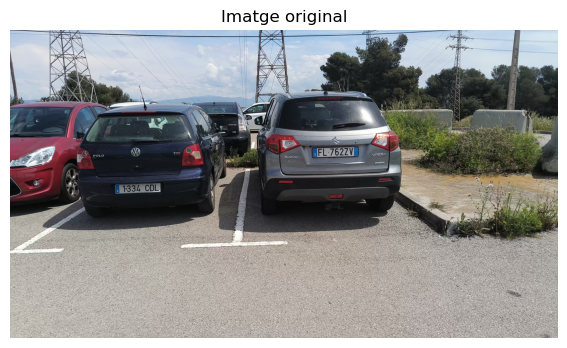

In [31]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

# --- FUNCIONS UTILS ---
def show_image(img, title="", cmap='gray'):
    plt.figure(figsize=(12, 4))
    if len(img.shape) == 2:
        plt.imshow(img, cmap=cmap)
    else:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()

# --- CARREGAR IMATGE ---
image = cv2.imread("frames/frame_0001.jpg")
if image is None:
    print("Error: no s'ha pogut carregar la imatge.")
    exit()
show_image(image, "Imatge original")


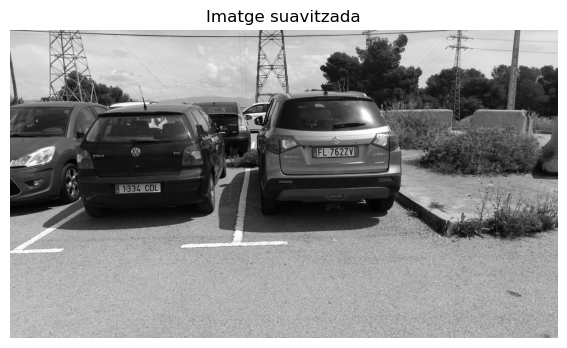

In [32]:
# --- PROCESSAMENT PREVI ---
# Convertir a escala de grisos
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray_blur = cv2.GaussianBlur(gray, (5, 5), 0)
median_blur = cv2.medianBlur(gray_blur, 5)
show_image(median_blur, "Imatge suavitzada")

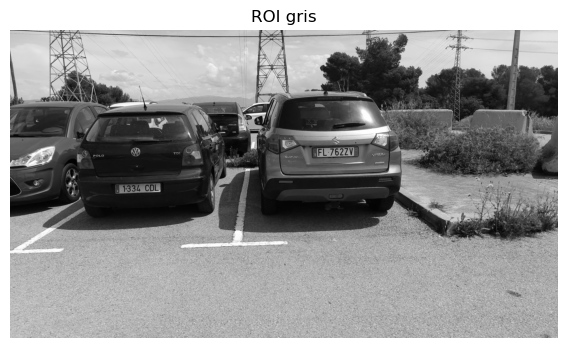

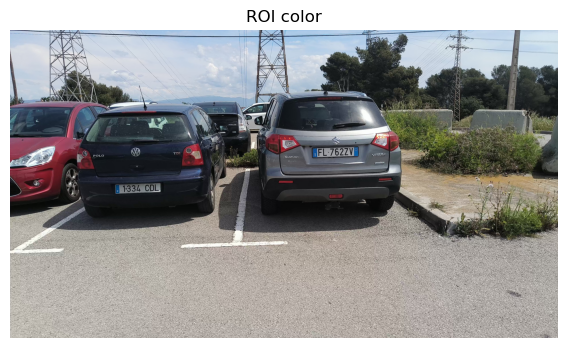

In [33]:
# --- ROI (zona inferior per a línies d'aparcament) ---
#offset_y = int(image.shape[0] * 0.3)
offset_y = int(image.shape[0] * 0)
roi = median_blur[offset_y:]
roi_color = image[offset_y:]
show_image(roi, "ROI gris")
show_image(roi_color, "ROI color")

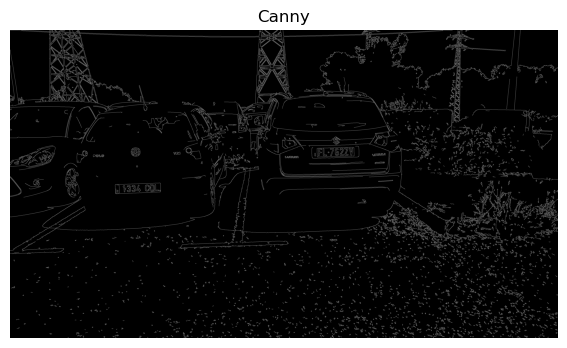

In [34]:
# --- CANNY + HOUGH ---
edges = cv2.Canny(roi, 100, 250)
lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=80, minLineLength=50, maxLineGap=30)
show_image(edges, "Canny")




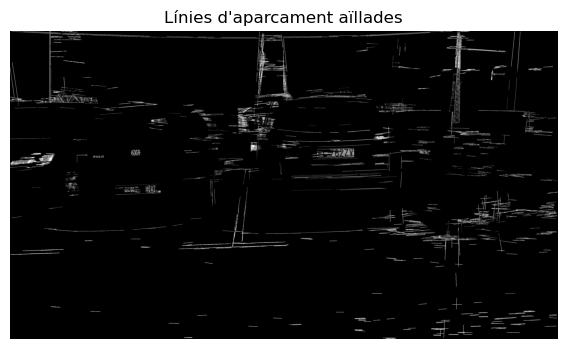

In [35]:
# Aïllar línies d'aparcament i calcular si hi ha cotxe entre elles
line_mask = np.zeros_like(edges)
line_segments = []
if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        angle = np.degrees(np.arctan2((y2 - y1), (x2 - x1)))
        if abs(angle) < 10 or abs(angle - 90) < 10 or abs(angle + 90) < 10:
            cv2.line(line_mask, (x1, y1), (x2, y2), 255, 2)
            line_segments.append(((x1, y1), (x2, y2)))

# Superposar màscara de línies a ROI original
lines_img = roi_color.copy()
lines_img[line_mask > 0] = [0, 255, 0]


# --- DETECCIÓ DE COTXES ENTRE LÍNIES ---
# Aquest exemple només mostra la màscara combinada per a futures comparacions
# En projectes reals, s'utilitzarien bounding boxes o detecció de vehicles
combined_mask = cv2.bitwise_and(roi, roi, mask=line_mask)
show_image(combined_mask, "Línies d'aparcament aïllades")


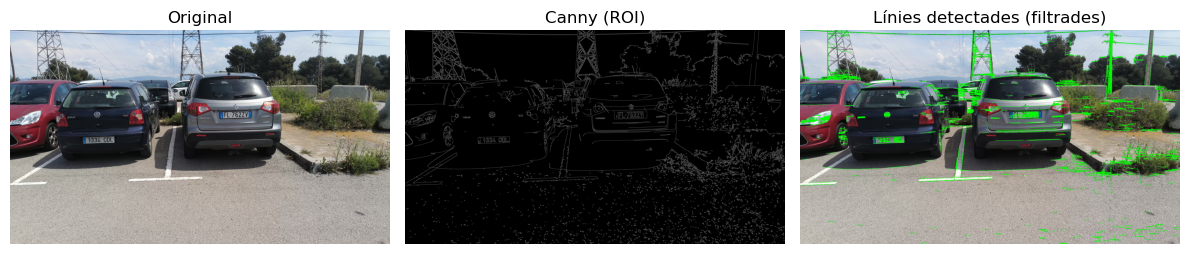

In [36]:
# --- VISUALITZACIÓ FINAL ---
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.title("Original")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Canny (ROI)")
plt.imshow(edges, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Línies detectades (filtrades)")
plt.imshow(cv2.cvtColor(lines_img, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.tight_layout()
plt.show()


Ara que tenim les lineas detectades correctament podem començar a detectar si el cotxe esta correctament estacionat

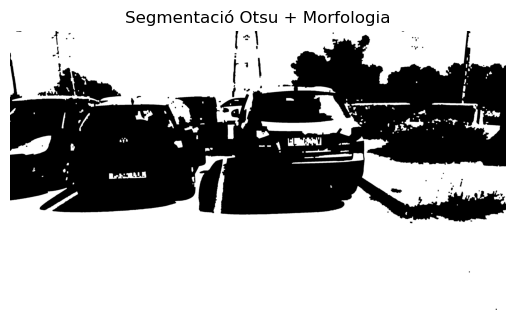

In [40]:
# --- DETECCIÓ DELS COTXE AMB OTSU + MORFOLOGIA ---
_, bin_otsu = cv2.threshold(roi, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7, 7))
closed = cv2.morphologyEx(bin_otsu, cv2.MORPH_CLOSE, kernel)
opened = cv2.morphologyEx(closed, cv2.MORPH_OPEN, kernel)

plt.title("Segmentació Otsu + Morfologia")
plt.imshow(opened, cmap='gray')
plt.axis('off')
plt.show()


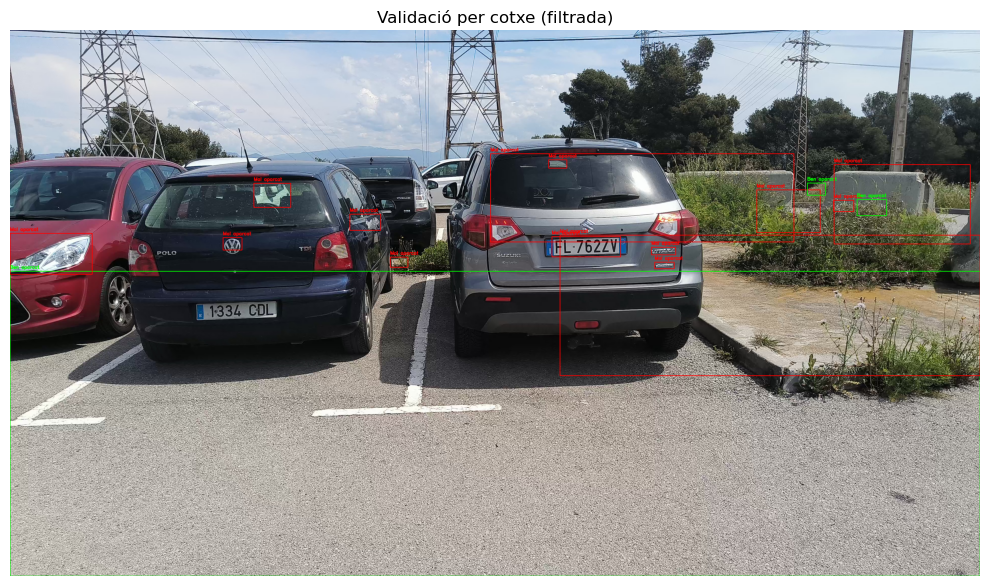

In [42]:

# Opcional: agrupar contorns propers per evitar deteccions múltiples d’un mateix cotxe
opened = cv2.dilate(opened, kernel, iterations=1)

# --- DETECCIÓ DE CONTORNS ---
contours, _ = cv2.findContours(opened, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
result_img = roi_color.copy()

for i, cnt in enumerate(contours):
    x, y, w, h = cv2.boundingRect(cnt)
    area = w * h
    aspect_ratio = w / h if h != 0 else 0

    # Filtrar per mida i forma de cotxe
    if area < 1500 or aspect_ratio < 1.2 or aspect_ratio > 3.5:
        continue

    mask = np.zeros_like(line_mask)
    cv2.drawContours(mask, [cnt], -1, 255, -1)
    overlap = cv2.bitwise_and(mask, line_mask)
    overlap_ratio = np.sum(overlap > 0) / area

    if overlap_ratio > 0.02:
        status = "Mal aparcat"
        color = (0, 0, 255)
    else:
        status = "Ben aparcat"
        color = (0, 255, 0)

    cv2.rectangle(result_img, (x, y), (x+w, y+h), color, 2)
    cv2.putText(result_img, status, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

# --- VISUALITZACIÓ FINAL ---
plt.figure(figsize=(10, 6))
plt.title("Validació per cotxe (filtrada)")
plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.tight_layout()
plt.show()
